### Checking Compression Results

In [1]:
cd ../

/home/agajan/DeepMRI


In [2]:
import torch
import torch.nn as nn
from deepmri.Datasets import Volume3dDataset
import deepmri.utils as utils
from Compression.ConvEncoder import ConvEncoder
from Compression.ConvDecoder import ConvDecoder
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import nibabel as nib
import time
import os
import numpy as np
%matplotlib inline

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda:0


In [21]:
data_path = '/media/schultz/345de007-c698-4c33-93c1-3964b99c5df6/agajan/experiment_Compression/data/'
img = nib.load(os.path.join(data_path, 'sub_01_data.nii.gz'))
img_data = img.get_data()
print(np.min(img_data), np.max(img_data))
data = torch.tensor(img_data).unsqueeze(0).unsqueeze(0).float()
mu = data.mean()
std = data.std()
data = (data - mu) / std
data = data.to(device)

x_coord = 88
y_coord = 115
z_coord = 100

print("Volume shape:", data.shape)
print("Minimum voxel value: {}, Maximum voxel value: {}".format(torch.min(data), torch.max(data)))

0 2242
Volume shape: torch.Size([1, 1, 176, 229, 200])
Minimum voxel value: -0.9237449169158936, Maximum voxel value: 6.973642349243164


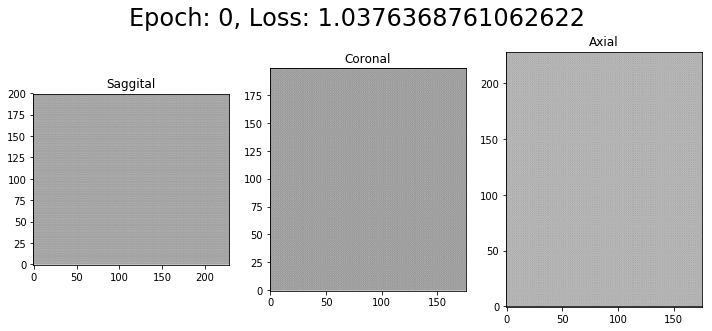

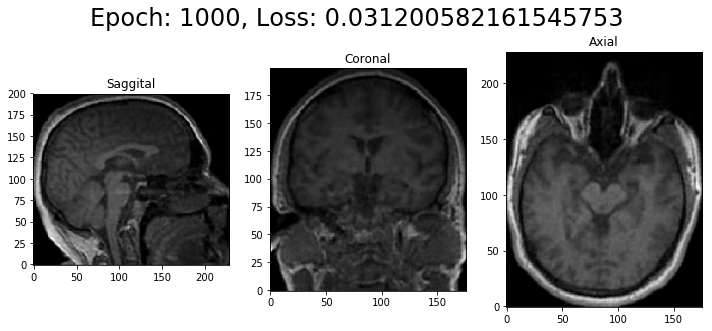

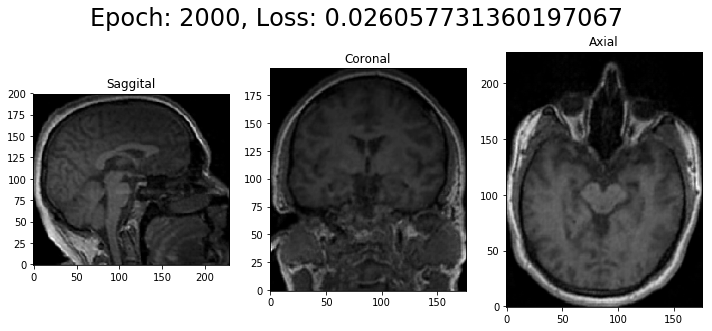

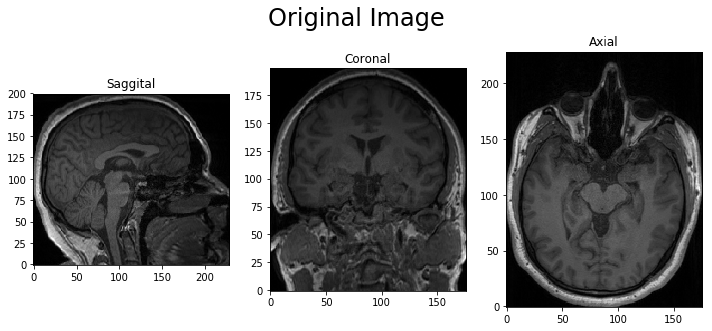

In [5]:
encoder = ConvEncoder(input_channels=1)
encoder.to(device)
encoder.eval()

decoder = ConvDecoder(out_channels=1)
decoder.to(device)
decoder.eval()

criterion = nn.MSELoss()

# before training
with torch.no_grad():
    running_loss = 0.0
    encoder.eval()
    decoder.eval()
    
    x = data
    out_0 = decoder(encoder(x))
    loss = criterion(x, out_0)
    running_loss += loss.item() * data.size(0)

epoch_loss = running_loss / 1.
suptitle = "Epoch: {}, Loss: {}".format(0, epoch_loss)
utils.show_slices([
    out_0[0, 0, x_coord, :, :].cpu().numpy(),
    out_0[0, 0, :, y_coord, :].cpu().numpy(),
    out_0[0, 0, :, :, z_coord].cpu().numpy(),
], figsize=(10, 5), suptitle=suptitle)

epochs = [1000, 2000]
for epoch in epochs:
    encoder_path = 'Compression/models/encoder_epoch_' + str(epoch)
    decoder_path = 'Compression/models/decoder_epoch_' + str(epoch)
    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path))

    with torch.no_grad():
        running_loss = 0.0
        encoder.eval()
        decoder.eval()
        x = data
        out = decoder(encoder(x))
        loss = criterion(x, out)
        running_loss += loss.item() * data.size(0)
    
    epoch_loss = running_loss / 1.
    suptitle = "Epoch: {}, Loss: {}".format(epoch, epoch_loss)
    utils.show_slices([
        out[0, 0, x_coord, :, :].cpu().numpy(),
        out[0, 0, :, y_coord, :].cpu().numpy(),
        out[0, 0, :, :, z_coord].cpu().numpy(),
    ], figsize=(10, 5), suptitle=suptitle)

# show original image
utils.show_slices([
    data[0, 0, x_coord, :, :].cpu().numpy(),
    data[0, 0, :, y_coord, :].cpu().numpy(),
    data[0, 0, :, :, z_coord].cpu().numpy(),
], figsize=(10, 5), suptitle="Original Image")

### Compression

In [14]:
encoder = ConvEncoder(input_channels=1)
encoder.to(device)
encoder.eval()

decoder = ConvDecoder(out_channels=1)
decoder.to(device)
decoder.eval()

# epoch = 1000
# encoder_path = 'Compression/models/encoder_epoch_' + str(epoch)
# decoder_path = 'Compression/models/decoder_epoch_' + str(epoch)
# encoder.load_state_dict(torch.load(encoder_path))
# decoder.load_state_dict(torch.load(decoder_path))

with torch.no_grad():
    # encoe
    feature = encoder(data)
    
    # decode
    out = decoder(feature)
    
    # clone data
    recons = out.detach().cpu().squeeze().clone()
    
    # unnormalize
    recons = recons * std + mu
    
    # convert to numpy
    recons = recons.numpy()
    
    
    # remove negative values
    recons = recons.clip(min=0)
    
    # floor
    recons = np.floor(recons)
    
    # get the residual
    residual = img_data - recons
    
    # convert to int
    residual = residual.astype('float32')
    
    feature = feature.detach().squeeze().cpu().numpy()
    print("Feature shape: ", feature.shape)
    
    # save feature
    np.savez_compressed("Compression/outputs/feature", feature)
    # save residual
    np.savez_compressed("Compression/outputs/residual", residual)
    
    print("Saved")

Feature shape:  (128, 11, 15, 13)
Saved


In [15]:
loss1 = criterion(torch.tensor(img_data).float(), torch.tensor(recons).float())
loss2 = criterion(torch.tensor(img_data).float(), 
                  torch.tensor(recons).float() + torch.tensor(residual.astype('float32')).float())
print(loss1, loss2)

tensor(82236.) tensor(0.)


In [16]:
np.min(residual), np.max(residual)

(-304.0, 1938.0)

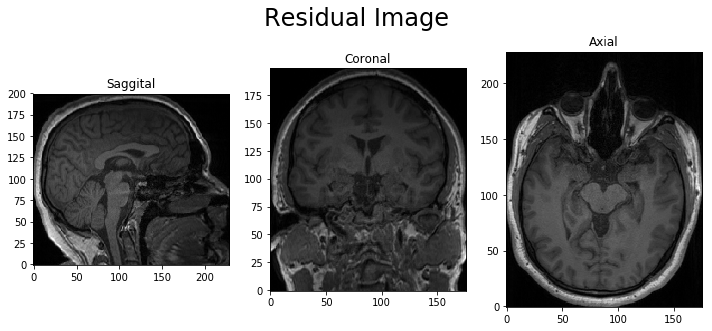

In [17]:
utils.show_slices([
    residual[x_coord, :, :],
    residual[:, y_coord, :],
    residual[:, :, z_coord],
], figsize=(10, 5), suptitle="Residual Image")

In [20]:
test_feature = torch.randn(64, 11, 15, 13).numpy()
np.savez_compressed("Compression/outputs/test_feature", test_feature)

In [24]:
print(img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 48
dim             : [  3 176 229 200   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.540000e+00
 1.000000e+00 1.000000e+00 4.934165e+04]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 175
slice_code      : sequential increasing
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 255
glmin           : 0
descrip         : b'TE=2.339999914;sec=49341.6500;phaseDir=+'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.00087